In [1]:
# 계정 선택해서 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import numpy as np #matrix, cpp 계산하는 라이브러리
import cv2 ##opencv, computer vision --> (numpy) cpp
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage ##scikit-image
from skimage.morphology import convex_hull_image
import time
import math
from tqdm.notebook import tqdm #작업 progress 확인

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)

##Image Preprocessing

In [ ]:
def img_preprocess2(img):

  img_gauss = cv2.GaussianBlur(img_gray, (3, 3), 0) # 가우스 노이즈 제거

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_gauss)
  img_adpt = cv2.adaptiveThreshold(img_cl, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
  img_adpt = 255 - img_adpt

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

  img_res = img_adpt.copy()

  img_res = cv2.medianBlur(img_res, 3)
  img_res = cv2.morphologyEx(img_res, cv2.MORPH_CLOSE, kernel, iterations=1)
  img_res = cv2.medianBlur(img_res, 3)
  img_res = cv2.medianBlur(img_res, 3)

  # skeletonization

  img_thinned = np.where(img_res==255, 1, img_res)
  img_thinned = skeletonize(img_thinned)
  img_thinned = img_thinned.astype(np.uint8)
  plt.imshow(img_thinned, cmap='gray')

  #convex_hull 이용하여 주변 노이즈 제거
  img_convexed = convex_hull_image(img_thinned)
  plt.imshow(img_convexed, cmap='gray')


  return img_res, img_convexed

In [ ]:
import fingerprint_enhancer
def img_preprocessing(img):
  img_enhanced = fingerprint_enhancer.enhance_Fingerprint(img)
  # plt.imshow(out, cmap='gray') 

  img_thinned = np.where(img_res==255, 1, img_res)
  img_thinned = skeletonize(img_thinned)
  img_thinned = img_thinned.astype(np.uint8)
  plt.imshow(img_thinned, cmap='gray')

  #convex_hull 이용하여 주변 노이즈 제거
  img_convexed = convex_hull_image(img_thinned)
  plt.imshow(img_convexed, cmap='gray')

  return img_enhanced, img_convexed

##Feature Extract

In [ ]:
#feature extract 코드

def get_fp_feature(img, flg_show):
  %%time

  img_res, img_pre = img_preprocess(img)
  ks = 3
  kernel = np.ones((ks, ks)) / (ks*ks)
  # print(kernel)

  rows, cols = img_pre.shape[:2]
  # print(rows, cols)
  img_filtered = np.zeros(img_pre.shape, dtype=np.uint8)

  end = [][]
  bif = [][]

  for i in tqdm(range(1,rows-1)):
      for j in range(1,cols-1):
          # block = img[i-1:i+2,j-1:j+2]
          result = 0
          for k_i in range(0, len(kernel)):
              for k_j in range(0, len(kernel[0])):
                  # result += img1[i, j] * kernel[k_i, k_j]  # correlation
                  result += img_pre[i-ks//2+k_i, j-ks//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j]  # convolution
          img_filtered[i, j] = int(result)
          if(img_filetered[i, j] == 2):
            end.insert([i, j])
          if(img_filtered[i, j] == 4):
            bif.insert([i, j])

  # print(img1.max(), img_filtered.max())

  # plt.imshow(cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB))


  if(flg_show = True) :
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(img_res)
    plt.subplot(1,3,3)
    plt.imshow(img_pre)

  return end, bif

##Matching

In [ ]:
train_path = '/content/gdrive/MyDrive/train_ref'
test2_path = '/content/gdrive/MyDrive/test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))

477 1428


data/selected/test2/100_type1.BMP 100 data/selected/train_ref/100.BMP


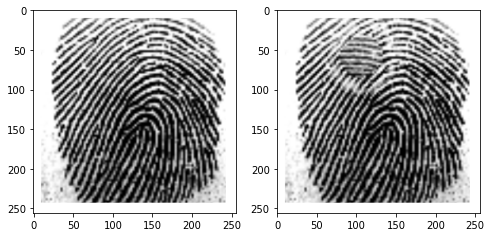

In [ ]:
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path)
img_test = cv2.imread(target_path)

plt.subplot(1,2,1)
plt.imshow(img_train, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_test, cmap='gray')


In [ ]:
def match_finger(feat_query, feat_db_x, n, img_query, img_train) :

  #Scikit Learn 사용해 원소 간 거리구하기

In [ ]:
dict_result = {}
for t in tqdm(list_train):
    basename = os.path.basename(t)
    img_train2 = cv2.imread(t)
    db_x_end, db_x_bif = get_fp_feature(img_train, False)
    feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
    dist, dist_half, len_match = match_finger(feat_query, feat_db_x, 50, False, img_query=img_test, img_train=img_train2)
    # print(dist, dist_half)
    dict_result[basename] = [dist, dist_half, len_match, len(feat_query), len(feat_db_x)]

  0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
dict_result

{'1.BMP': [340.4480068683624, 93.74949765205383, 29, 120, 108],
 '10.BMP': [445.9393701553345, 97.43551254272461, 66, 120, 256],
 '100.BMP': [26.171077013015747, 0.0, 100, 120, 102],
 '101.BMP': [291.7629566192627, 75.43599700927734, 25, 120, 84],
 '102.BMP': [385.58453488349915, 83.91641306877136, 58, 120, 209],
 '104.BMP': [437.9827779531479, 122.91438138484955, 46, 120, 142],
 '105.BMP': [582.7907665967941, 143.5651491880417, 61, 120, 172],
 '106.BMP': [440.008132815361, 105.96008861064911, 57, 120, 176],
 '107.BMP': [253.74766266345978, 39.728816628456116, 29, 120, 103],
 '108.BMP': [404.53524565696716, 99.3465006351471, 43, 120, 121],
 '11.BMP': [349.80949807167053, 91.03306317329407, 32, 120, 72],
 '111.BMP': [446.70002341270447, 107.75078845024109, 43, 120, 123],
 '112.BMP': [301.3451189994812, 91.2564787864685, 46, 120, 198],
 '113.BMP': [403.71186435222626, 98.3516925573349, 56, 120, 239],
 '116.BMP': [455.36264646053314, 78.21514022350311, 45, 120, 131],
 '12.BMP': [235.12996

##Metric 계산

In [ ]:
def FAR(mth, dth, num) :
  FAR = 0
  i = num-1
  for j in range(10*i, 10*i+2):
    dcnt = 0
    for n in range(0,8):
      if(i==n):
        continue
      for k in range(10*n+2, 10*(n+1)):
        mr = match(mnt_fname[j], mnt_fname[k], mth)
        if(mr>=dth):
          dcnt+=1
    FAR+=dcnt/56*100

  FAR = FAR2
  return FAR

In [ ]:
def FRR(mth, dth, num) :
  FRR = 0
  i = num-1
  for j in range(10*i, 10*i+2):
    dcnt=0
    for k in range(10*i+2, 10*(i+1)):
      mr = match(mnt_fname[j], mnt_fname[k], mth)
      if(mr>=dth):
        dcnt+=1
    FRR += (8-dcnt)/8*100
  FRR=FRR/2
  return FRR